In [15]:
from torch.utils.data import Dataset, DataLoader
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from transformers.optimization import AdamW
from nltk.translate.bleu_score import corpus_bleu
import torch
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [41]:
class LanguageDataset(Dataset):                                  

    def __init__(self, ne_file, en_file, max_length, tokenizer):
        self.ne_file = ne_file
        self.en_file = en_file
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.ne_token = []
        self.en_token = []
        self.en = []
        self.ne = []
        with open(self.ne_file) as file:
            for sentence in file:
                sentence = sentence.strip()
                tokens = tokenizer(sentence, max_length=self.max_length, return_tensors="pt", truncation=True, padding='max_length')
                self.ne.append(sentence)
                self.ne_token.append(tokens)
        with open(self.en_file) as file_en:
            for sentence in file_en:
                #padding token -100
                sentence = sentence.strip()
                tokens = tokenizer(sentence, max_length=self.max_length, return_tensors="pt", truncation=True, padding='max_length')
                tokens['input_ids'][tokens['attention_mask'] == 0] = -100
                self.en.append(sentence)
                self.en_token.append(tokens)
                    
    def __len__(self):
        return len(self.ne_token)
              
    # input_ids attention_mask encoder_mask decoder_mask 
    def __getitem__(self, idx):
        return {
            'ne_tokens': self.ne_token[idx]['input_ids'][0],
            'ne_mask': self.ne_token[idx]['attention_mask'][0],
            'en_tokens': self.en_token[idx]['input_ids'][0],
            'en_mask': self.en_token[idx]['attention_mask'][0],
            'en': self.en[idx],
            'ne': self.ne[idx]
        }

In [42]:
# datasets
DIR_PATH = "/workspace"
MAX_LENGTH = 100
BATCH_SIZE = 8
# A flag to see whether we are fine-tuning the model or not
fine_tune = True

In [43]:
#initlaize model and tokenizer
model_name = "facebook/mbart-large-50-many-to-many-mmt"
model = MBartForConditionalGeneration.from_pretrained(model_name)
model = model.cuda()
tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
tokenizer.src_lang = "ne_NP"
tokenizer.tgt_lang = "en_XX"

In [44]:
print(tokenizer.pad_token)
print(tokenizer.pad_token_id)
output = tokenizer("<pad>", return_tensors="pt")['input_ids'][0]
print(output)
decoded = tokenizer.decode(output, skip_special_tokens=True)
print(decoded)
tokens = tokenizer("hi i am", max_length=10, return_tensors="pt", truncation=True, padding='max_length')
tokens['input_ids'][tokens['attention_mask'] == 0] = -100
print(tokens)

<pad>
1
tensor([250018,      1,      2])

{'input_ids': tensor([[250018,   1274,     17,    444,      2,   -100,   -100,   -100,   -100,
           -100]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])}


In [45]:
print('prepping data')
train_dataset = LanguageDataset(f'{DIR_PATH}/train.ne_NP.txt', f'{DIR_PATH}/train.en_XX.txt', MAX_LENGTH, tokenizer)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
print('done')

prepping data
done


In [47]:
print(train_dataset[0])

{'ne_tokens': tensor([250018,   4623,  31422,  10949, 106283,  86561,   6945,      2,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1]), 'ne_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [48]:
'''
Perform fine-tuning of mBART in case the flag is set appropriately
You can check out references like these to understand the code better:
    - https://colab.research.google.com/drive/1d2mSWLiv93X2hgt9WV8IJFms9dQ6arLn?usp=sharing
    - https://github.com/huggingface/transformers/issues/23185#issuecomment-1537690520
'''

if fine_tune:
    print('fine-tuning')
    # Moving the model to CUDA
    model = model.cuda()

    optimizer = AdamW(model.parameters(), lr=1e-5)
    model.train()
    
    num_epochs = 10
    training_losses = []  # Track training loss for each batch

    # Fine-tune for the specified number of epochs
    for i in range(num_epochs):
        print(f'epoch {i+1} of {num_epochs}')
        
        total_batches = len(train_loader)
        epoch_loss = 0
        
        for batch in tqdm(train_loader, total=total_batches, desc="Training", unit="batch"):
            model_inputs = {
                'input_ids': batch['ne_tokens'].to('cuda'),
                'attention_mask': batch['ne_mask'].to('cuda')
            }
            labels = batch['en_tokens'].to('cuda')
            optimizer.zero_grad()
            output = model(**model_inputs, labels=labels)  # Forward pass
            loss = output.loss
            epoch_loss = loss.cpu().detach().numpy() + epoch_loss
            loss.backward()  # Backward pass
            optimizer.step()

        epoch_loss = epoch_loss/total_batches
        print(f'epoch loss {epoch_loss}')
        training_losses.append(epoch_loss)

    model.save()
    
    # Plot the training loss
    plt.plot(training_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


fine-tuning
epoch 1 of 10


Training: 100%|██████████| 13472/13472 [1:12:32<00:00,  3.10batch/s]


epoch loss 0.969506259362773
epoch 2 of 10


Training:  51%|█████     | 6815/13472 [36:42<35:48,  3.10batch/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training:  93%|█████████▎| 12552/13472 [1:07:37<04:56,  3.10batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training: 100%|██████████| 13472/13472 [1:12:33<00:00,  3.09batch/s]


epoch loss 0.5814453787532593
epoch 4 of 10


Training:  26%|██▋       | 3553/13472 [19:08<53:39,  3.08batch/s]  ]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



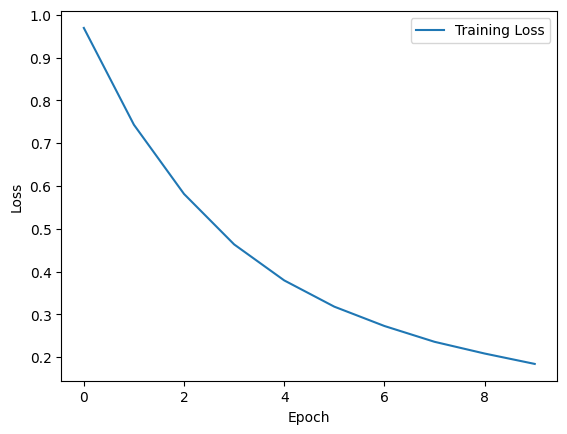

In [53]:
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
test_dataset = LanguageDataset(f'{DIR_PATH}/test.ne_NP.txt', f'{DIR_PATH}/test.en_XX.txt', BATCH_SIZE, tokenizer)

#init generated translations
generated_translations = []
reference = []

#for each nepali sentence, generate english translation, and add to generated translations
for sentence in test_dataset:

    input_ids = tokenizer(sentence['ne'], return_tensors="pt").input_ids.to('cuda')
    forced_bos_token_id = tokenizer.lang_code_to_id["en_XX"]
    # input_ids = sentence['en_tokens'].to('cuda').reshape(1, -1)
    outputs = model.generate(input_ids=input_ids, forced_bos_token_id=forced_bos_token_id, max_length=BATCH_SIZE)
    english_translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    generated_translations.append(english_translation)

    reference.append(sentence['en'])
    
hypotheses = [gen.split() for gen in generated_translations]
references = [[ref.split()] for ref in reference]

bleu_score = corpus_bleu(references, hypotheses)

print("bleu score: ", bleu_score)

bleu score:  0.0005257933144865067


In [59]:
print(hypotheses[6])
print(references[6])

['He', 'rang', 'the', 'bell']
[['He', 'built', 'a', 'WiFi', 'door', 'bell,', 'he', 'said.']]


In [9]:
# Test
#get nepali sentences and english references
dataset_np = load_dataset("text", data_files= {"train": f"{DIR_PATH}/train.ne_NP.txt", "test": f"{DIR_PATH}/test.ne_NP.txt"})
dataset_en = load_dataset("text", data_files={"train": f"{DIR_PATH}/train.en_XX.txt", "test": f"{DIR_PATH}/test.en_XX.txt"})
nepali_sentences = dataset_np["test"]
english_references = dataset_en["test"]

#init generated translations
generated_translations = []

#for each nepali sentence, generate english translation, and add to generated translations
for nepali_sentence in nepali_sentences:

    input_ids = tokenizer(nepali_sentence['text'], return_tensors="pt").input_ids.to('cuda')
    
    #find forced beginning of sentence token id
    forced_bos_token_id = tokenizer.lang_code_to_id["en_XX"]

    outputs = model.generate(input_ids=input_ids, forced_bos_token_id=forced_bos_token_id, max_length=BATCH_SIZE)

    #decode generated english translation back into a sentence
    english_translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # add english sentence to generated translations
    generated_translations.append(english_translation)

#calculate bleu score
# map each sentence to a [ sentence.split() ]

references = [[reference.split()] for reference in english_references["text"]]
hypotheses = [gen.split() for gen in generated_translations]

bleu_score = corpus_bleu(references, hypotheses)
print('references')
print(references)
print('hypotheses')
print(hypotheses)
print("bleu score: ", bleu_score)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

references
[[['"We', 'now', 'have', '4-month-old', 'mice', 'that', 'are', 'non-diabetic', 'that', 'used', 'to', 'be', 'diabetic,"', 'he', 'added.']], [['Dr.', 'Ehud', 'Ur,', 'professor', 'of', 'medicine', 'at', 'Dalhousie', 'University', 'in', 'Halifax,', 'Nova', 'Scotia', 'and', 'chair', 'of', 'the', 'clinical', 'and', 'scientific', 'division', 'of', 'the', 'Canadian', 'Diabetes', 'Association', 'cautioned', 'that', 'the', 'research', 'is', 'still', 'in', 'its', 'early', 'days.']], [['Like', 'some', 'other', 'experts,', 'he', 'is', 'skeptical', 'about', 'whether', 'diabetes', 'can', 'be', 'cured,', 'noting', 'that', 'these', 'findings', 'have', 'no', 'relevance', 'to', 'people', 'who', 'already', 'have', 'Type', '1', 'diabetes.']], [['On', 'Monday,', 'Sara', 'Danius,', 'permanent', 'secretary', 'of', 'the', 'Nobel', 'Committee', 'for', 'Literature', 'at', 'the', 'Swedish', 'Academy,', 'publicly', 'announced', 'during', 'a', 'radio', 'program', 'on', 'Sveriges', 'Radio', 'in', 'Sweden'